In [1]:
import os
import sys
import numpy as np
import cftime
import xarray as xr
import osmnx as ox
import matplotlib.pyplot as plt
import mplotutils as mpu
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.ops import unary_union


In [2]:
#Read main path
with open('../path_main.txt', 'r') as file:    path_main  = file.read()
    
dir_fig       = f'{path_main}Figures/Paper_v2/'
dir_data_Ymax = f'{path_main}Data/EURO-CORDEX/Yearmax/'


## Plot

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: 

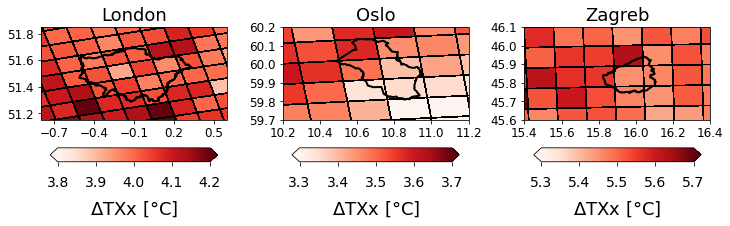

In [5]:
#Read data
data = xr.open_dataset(dir_data_Ymax + 'TXx_all_models_yearmax.nc')
data = data.median('model')

#Define cities
# cities = ['London', 'Berlin', 'Paris']
cities = ['London', 'Oslo', 'Zagreb']#'Barcelona']

#Create figure
fig, axes = plt.subplots(1, 3, figsize=(12, 4), subplot_kw=dict(projection=ccrs.PlateCarree()))
plt.subplots_adjust(wspace=0.3)

#Define coordinate extents
extents = dict()
extents['Paris']     = [1.8, 3, 48.5, 49]
extents['London']    = [-0.8, 0.6, 51.15, 51.85]
extents['Berlin']    = [12.8, 14, 52.2, 52.8]
extents['Zagreb']    = [15.4, 16.4, 45.6, 46.1]
extents['Oslo']      = [10.2, 11.2, 59.7, 60.2]
extents['Stockholm'] = [17.5, 18.5, 59, 59.5]
extents['Barcelona'] = [2, 2.4, 41.2, 41.6]

#Define colormap limits
lims = dict()
lims['Paris']     = [0, 6]     #[1.5, 3]
lims['London']    = [3.8, 4.2] #[-1, 1]
lims['Berlin']    = [0, 6]     #[-2, -1]
lims['Zagreb']    = [5.3, 5.7] #[-2, 2]
lims['Oslo']      = [3.3, 3.7] #[-6, 2]
lims['Stockholm'] = [0, 6]     #[-2, 2]
lims['Barcelona'] = [2, 6]     #[-2, 2]

#Loop over cities
for i, city in enumerate(cities):

    ax = axes[i]

    #Get the city boundaries
    if city=='London':
        gdf1 = ox.geocode_to_gdf({'city': 'City of London'})
        gdf2 = ox.geocode_to_gdf({'city': 'London'})
        gdf = unary_union([gdf1.geometry[0], gdf2.geometry[0]])
        gdf = gpd.GeoSeries(gdf)
    else:
        gdf = ox.geocode_to_gdf({'city': city})
    
    #Get limits    
    vmin = lims[city][0]
    vmax = lims[city][1]
    
    #Plot grid
    ax.pcolormesh(data['lon'], data['lat'], ~np.isnan(data['TXx']), transform=ccrs.PlateCarree(), facecolor='None', edgecolors='k', zorder=2, cmap='Greys_r', linewidth=0.75)#, shading='auto', cmap='RdBu_r', vmin=-1, vmax=1, rasterized=True)
    h1 = ax.pcolormesh(data['lon'], data['lat'], data['TXx'], transform=ccrs.PlateCarree(), shading='auto', cmap='Reds', vmin=vmin, vmax=vmax, rasterized=True)
    
    #Plot city borders
    shape_feature = cfeature.ShapelyFeature(gdf.geometry, ccrs.PlateCarree(), facecolor="lime", edgecolor='black', lw=1)
    ax.add_feature(shape_feature, facecolor='none', edgecolor='k', linewidth=2)
    
    #Set extent and title
    ax.set_extent(extents[city], crs=ccrs.PlateCarree())
    ax.set_title(city, fontsize=18)
    
    #Add x- and y-ticks
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    
    #Define spacing of x-ticks and y-ticks
    n_space_lon = 0.2
    n_space_lat = 0.1
    if np.abs(np.diff(extents[city][0:2]))>1:
        n_space_lon = 0.3
    if np.abs(np.diff(extents[city][2:4]))>0.5:
        n_space_lat = 0.2
    
    #Set x-ticks and y-ticks and limits
    xticks = ax.set_xticks(np.arange(-25, 50, n_space_lon))
    yticks = ax.set_yticks(np.arange(0, 90, n_space_lat))
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    #Colorbar
    cbar = mpu.colorbar(h1, ax, orientation='horizontal', extend='both', size=0.15, shrink=0.1, pad=0.3)
    cbar.ax.tick_params(labelsize=14, pad=10)
    cbar.set_label('$\Delta$TXx [°C]', fontsize=18, labelpad=10)\
    
    #Set colorbar ticks
    if np.diff(lims[city])<=0.5:
        cbar_ticks = np.arange(lims[city][0], lims[city][1] + 0.1, 0.1)
        cbar.set_ticks(cbar_ticks)
    elif np.diff(lims[city])<=1:
        cbar_ticks = np.arange(lims[city][0], lims[city][1] + 0.2, 0.2)
        cbar.set_ticks(cbar_ticks)
    
    #Set tick parameters
    ax.tick_params(labelsize=12)
    
#Save in file
fig.savefig(dir_fig + 'Fig1b_Cities_Europe_grid.png', dpi=200, bbox_inches='tight')
fig.savefig(dir_fig + 'Fig1b_Cities_Europe_grid.pdf', dpi=200, bbox_inches='tight')


In [4]:
# dir_check = f'{path_main}Data/EURO-CORDEX/Yearmax/tasmax/'
# files = [file for file in os.listdir(dir_check) if 'historical' in file]

# for file in files:
#     data = xr.open_dataset(dir_check + file)
    
#     if 'rlon' in data.dims:
#         print(len(data.rlon), end=' x ')
#         print(len(data.rlat))
#     else:
#         print(len(data.x), end=' x ')
#         print(len(data.y))